# Precipitation Forecasting using CNN-LSTM

In this Notebook, we investigate a hybrid Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) model to forecast precipitation. CNN-LSTM models combine the strengths of both CNNs and LSTMs to capture feature internal and temporal dependencies in sequential data. CNNs are useful for extracting local patterns and features from data through convolutional operations, while LSTMs are specialized recurrent neural networks designed to capture long-term dependencies by maintaining internal memory across sequential inputs. This combination allows the model to effectively learn complex patterns in weather data, where both relationships inbetween the features and temporal information are crucial for accurate forecasting.

## 0. Imports and Basic Setup

In [12]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Load Preprocessed Train, Validation, and Test Splits


In [13]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for LSTM

This function, which was also used for the RNN creates for each partition (train/val/test) sequences of length *seq_length* to predict *prec* on the "next" day. For example, X[t : t+seq_length] -> y[t+seq_length].

Important: Because data comes from multiple locations, the simplest approach is to do it location by location to avoid "splicing" between location boundaries. 

In [14]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    For each location independently, create sequences of length seq_length
    to predict the (seq_length+1)-th day's target_col.
    Returns:
        X: np.array of shape (num_samples, seq_length, num_features)
        y: np.array of shape (num_samples,)
    """
    X_list, y_list = [], []
    
    # Group by location so we don't mix data across different basins
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)  # reindex after grouping

        # Convert to numpy for slicing
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        # Slide over the time dimension for that location
        for i in range(len(loc_df) - seq_length):
            X_list.append(loc_features[i : i + seq_length])
            y_list.append(loc_target[i + seq_length])

    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

## 3. Define Features and Target

The target variable is "prec", while *all other numeric columns* from the preprocessed data are treated as potential features, except for location / date info.

In [15]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD", "prec"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate Sequence Datasets


In [16]:
SEQ_LENGTH = 30

X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202300, 30, 20) (1202300,)
Validation sequence shape: (106600, 30, 20) (106600,)
Test sequence shape: (106500, 30, 20) (106500,)


## 5. Build a CNN-LSTM Model in Keras

Now we will create a CNN-LSTM Model. Therefore, we start with a simple Convolutional Layer, which is then followed by a LSTM layer. Additionally, we add a dropout layer inbetween for regularization and to prevent overfitting.

In [17]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(feature_cols))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dense(units=1))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

c:\Users\jogip\OneDrive - TU Wien\Master\AI ML in the era of Climate Change\AMITECC_Ex2\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,603 (72.67 KB)

 Trainable params: 18,603 (72.67 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [18]:
BATCH_SIZE = 256
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 76s 16ms/step - loss: 0.8571 - mae: 0.5861 - val_loss: 0.8585 - val_mae: 0.5899
Epoch 2/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.8014 - mae: 0.5575 - val_loss: 0.8708 - val_mae: 0.5813
Epoch 3/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step - loss: 0.7767 - mae: 0.5485 - val_loss: 0.8626 - val_mae: 0.5817
Epoch 4/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.7530 - mae: 0.5423 - val_loss: 0.8568 - val_mae: 0.5896
Epoch 5/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - loss: 0.7275 - mae: 0.5352 - val_loss: 0.8700 - val_mae: 0.5936
Epoch 6/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - loss: 0.7192 - mae: 0.5315 - val_loss: 0.8643 - val_mae: 0.5811
Epoch 7/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - loss: 0.7074 - mae: 0.5286 - val_loss: 0.8911 - val_mae: 0.5948
Epoch 8/10
4697/4697 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step - loss: 0.6972 - mae: 0.5262 - val_loss: 0.8924 - val_mae: 0.5955
Epoch 9/10
4697/4697 ━━━

## 7. Evaluate the Model

In [19]:
val_preds = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Evaluate on test set
test_preds = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

3332/3332 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Validation MSE:  0.8948
Validation RMSE: 0.9459
Validation MAE:  0.5901
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test MSE:  0.8718
Test RMSE: 0.9337
Test MAE:  0.5906


## 8. Plot Training History

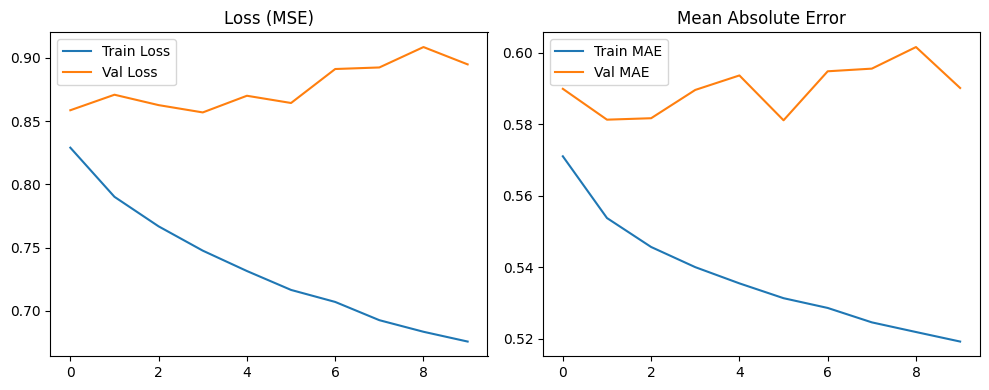

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (MSE)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()

## 9. Quick Prediction Visualization


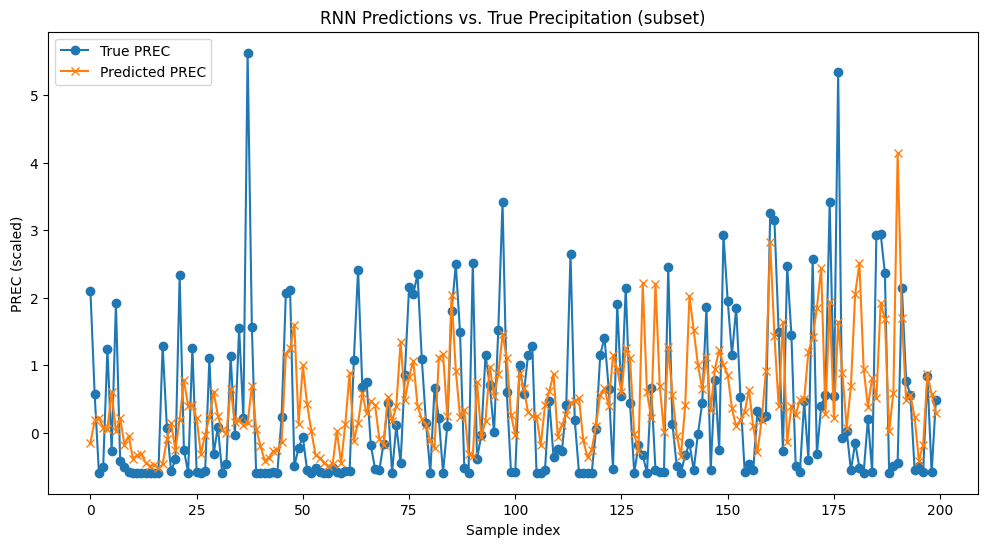

In [21]:
num_samples_to_plot = 200  # just pick some small subset 
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("RNN Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 10. Feature Importance Study

To investigate feature importance in the CNN-LSTM, we use the same permutation importance approach as for the RNN model.

The idea is to:
* Compute a baseline metric (e.g. MSE) using the unshuffled test data.
* For each feature in the input set, shuffle (i.e. randomly permute) just that one feature across all test samples (keeping other features intact).
* Run inference on this shuffled data and measure the new metric.
* The increase in error (Δ MSE) compared to the baseline is treated as an indicator of that feature’s importance.

This approach is model-agnostic and commonly used for neural networks such as RNNs, but also LSTMs or CNNs.

3329/3329 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Baseline Test MSE: 0.8718
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3329/3329 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Feature Importances (Permutation-based), sorted by ΔMSE:
Feature: surf_

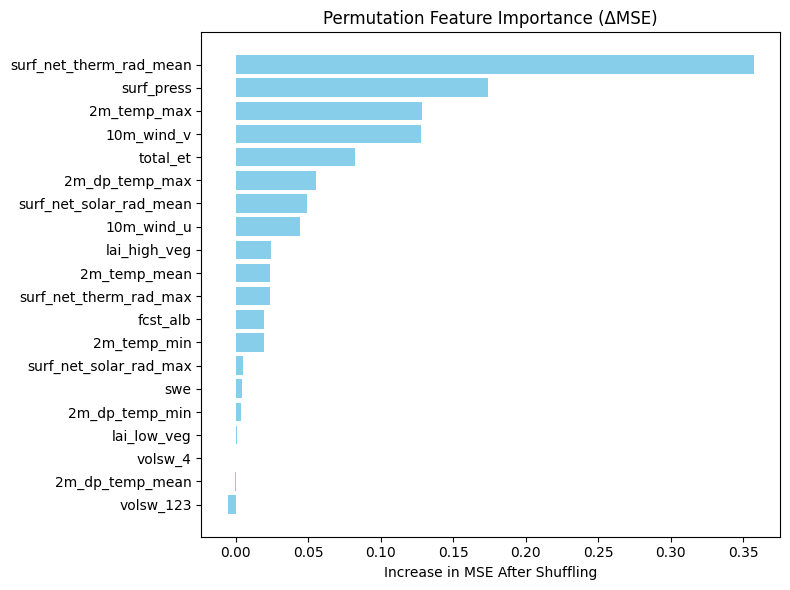

In [22]:
baseline_preds = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_preds)
print(f"Baseline Test MSE: {baseline_mse:.4f}")

def permutation_importance(model, X, y, baseline_mse):
    """
    For each feature, shuffle it across the dataset, compute new MSE, 
    and measure the difference from baseline_mse. 
    Returns:
       dict { feature_name: delta_mse }
    """
    feature_importances = {}
    X_copy = np.copy(X) 
    
    num_features = X.shape[-1]  # last dimension = number of features
    for f_idx in range(num_features):
        # Shuffle only the f_idx-th feature
        shuffled = np.copy(X_copy)
        np.random.shuffle(shuffled[:, :, f_idx])  # shuffle in-place across the sample dimension
        
        # Predict with the permuted data
        perm_preds = model.predict(shuffled)
        perm_mse = mean_squared_error(y, perm_preds)
        
        delta_mse = perm_mse - baseline_mse
        feature_name = feature_cols[f_idx]
        feature_importances[feature_name] = delta_mse
    
    return feature_importances

importances_dict = permutation_importance(model, X_test, y_test, baseline_mse)

sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (Permutation-based), sorted by ΔMSE:")
for feat, imp in sorted_importances:
    print(f"Feature: {feat:<30} | ΔMSE: {imp:.6f}")

plt.figure(figsize=(8, 6))
feat_names = [x[0] for x in sorted_importances]
deltas = [x[1] for x in sorted_importances]
plt.barh(feat_names, deltas, color='skyblue')
plt.title("Permutation Feature Importance (ΔMSE)")
plt.xlabel("Increase in MSE After Shuffling")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()